# Exemplo de Rede Neural Bayesiana

                        

O grande diferencial das Redes Neurais Bayesianas é que elas são capazes de identificar situações em que os dados fogem muito dos padrões de treinamento e em que a rede neural não deveria ser considerada como válida. 

É um modelo que tem a capacidade de sizer "não sei". 

Neste exercício, utilizamos o conjunto de dados Fashion Mnist que trás fotos de baixa resolução de itens de vestuário como camisestas, camisas, agasalhos, sanálias, tenis e botas. 

Tal conjunto de dados é interessante pois muitos itens tem características similares, por exemplo:
* vestidos curtos parecem camisetas;
* sandálias fechadas parecem tênis;
* tenis mais altos parecem botas; e
* etc.

Esta foi a principal categoria de indecisão do modelo e isto é muito útil para separar estes casos para treinamento de outra rede neural. Os casos em que havia clareza na categoria eram muito mais numerosos e dominaram o modelo. Tirando os casos óbvios o próximo modelo terá de procurar outras características para diferenciar as categorias. 




# 1. Inicialização e carga dos dados

## 1.1. Instalação dos pacotes necessários.

In [25]:
#          Sugiro executar o comando abaixo e reiniciar o jupyterlab
#          Ao retornar, acione o menu kernel, Change Kernel e selecione o venv_pytorch
#
#!python3 -m ipykernel install --user --name venv_pytorch

#!pip install scipy
#
#          O comando de instalação apropriado para o pytorch pode ser encontrado em http://pytorch.org
#
#!pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pyro-ppl==1.4.0
!pip install --upgrade matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [ ]:
if torch.cuda.device_count() != 0:
    print( f'torch.current_device={torch.cuda.current_device()}' )
    print( f'torch.current_device={torch.cuda.get_device_name(0)}' )
    gpu = torch.device("cuda")
else:
    print( f'No GPU detected' )   


torch.current_device=0
torch.current_device=GeForce 940MX


## 1.2 Carrega e padroniza os dados 

In [2]:
if False:

  classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  train_loader = torch.utils.data.DataLoader(
          datasets.MNIST(
              'mnist-data/', 
              train=True, 
              download=True,
              transform=transforms.Compose([
                  transforms.ToTensor(),
              ])
          ),
          batch_size=128,
          shuffle=True
  )

  test_loader = torch.utils.data.DataLoader(
          datasets.MNIST(
              'mnist-data/', 
              train=False, 
              transform=transforms.Compose([
                  transforms.ToTensor(),
              ] )
          ),
          batch_size=128, 
          shuffle=True
  )

In [8]:
if True:
  
  classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

  train_loader = torch.utils.data.DataLoader(
          datasets.FashionMNIST(
              'f-mnist-data/', 
              train=True, 
              download=True,
              transform=transforms.Compose([
                  transforms.ToTensor(),
              ])
          ),
          batch_size=128,
          shuffle=True
  )

  test_loader = torch.utils.data.DataLoader(
          datasets.FashionMNIST(
              'f-mnist-data/', 
              train=False, 
              transform=transforms.Compose([
                  transforms.ToTensor(),
              ] )
          ),
          batch_size=128, 
          shuffle=True
  )

# 2. Definições da Rede Neural Bayesiana

## 2.1 Rede Neural no PyTorch

Aqui é definida uma rede neural com uma camada escondida de 1024 neurônios no padrão do pytorch.

In [13]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output
    
net = NN(28*28, 1024, 10)

## 2.2. Definições Bayesianas no Pyro

Este bloco corresponde ao mapeanmento das distribuições associadas as camadas da rede neural, bem como da função de erro. 

In [15]:
log_softmax = nn.LogSoftmax(dim=1)

def model(x_data, y_data):
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)
    
    
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)

    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)

    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)

    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()




In [16]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

## 2.3. Treinamento

In [17]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  3192.7155924007257
Epoch  1  Loss  939.6644207089265
Epoch  2  Loss  346.0162296538512
Epoch  3  Loss  165.91649672665596
Epoch  4  Loss  112.47135571457545


# 3. Avaliação dos Resultados

In [46]:
#@title
def imshow(img):
    npimg = img.numpy()
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()
    
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("-------------------------------------------------------------")
            fig, axs = plt.subplots(1, 11, sharey=False,figsize=(20,2))
            axs[1].get_shared_y_axes().join(*(axs[1:]))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob > 0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j+1].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j+1].set_title(str(classes[j])+" ("+str(round(prob,2))+")") 
                
                if( j > 0 ):
                    #axs[j+1].sharey(axs[1])
                    #axs[j+1].sharex(axs[1])
                    axs[j+1].set_ylim([0.0,1.0])
                    #axs[j+1].set_xlim([-520,20])
                    axs[j+1].axes.get_yaxis().set_visible(False)
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            axs[0].set_axis_off()
            axs[0].imshow(images[i].squeeze(),interpolation='nearest')
            

    
        if(plot):
            plt.tight_layout()
            plt.show()
            
        predicted = np.argmax(all_digits_prob)
    
        if(plot):
            print("Real:", classes[labels[i].item()], '===> Predicted: ', end='')            
    
        
        if(highted_something):
            predicted_for_images += 1
            if(labels[i].item() == predicted):
                if(plot):
                    print("Correct")
                correct_predictions += 1.0
            else:
                if(plot):
                    print(f"Incorrect ({classes[predicted]})")
        else:
            if(plot):
                print("Undecided.")
        
        
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        if predicted_for_images > 0:
            print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

## 3.1. Avaliação das Predições

As células abaixo informam:
* a acurácia geral (considerando undecided=erro)
* a acurácia quando excetuando os casos que a rede apontou dúvida explicitamente.


In [18]:
#@title
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == labels.numpy()).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict


/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


accuracy: 71 %


In [22]:
#@title
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total - total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse


/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Total images:  10000
Skipped:  3609
Accuracy when made predictions: 89 %


## 3.2. Exemplos de classificação de imagens geradas aleatoriamente (ruido)

Em um modelo tradicional, o resultado seria identificado pela classe com maior score, então estes casos teriam predições efetuadas. 

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


-------------------------------------------------------------


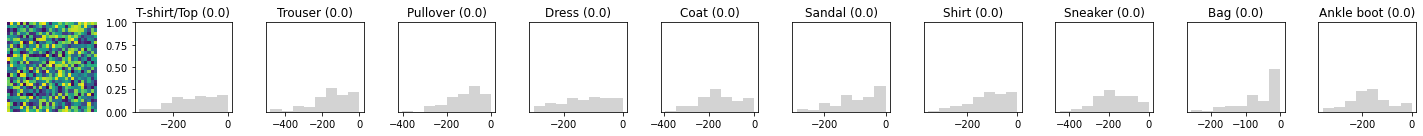

Real: T-shirt/Top ===> Predicted: Undecided.
Summary
Total images:  1
Predicted for:  0
-------------------------------------------------------------


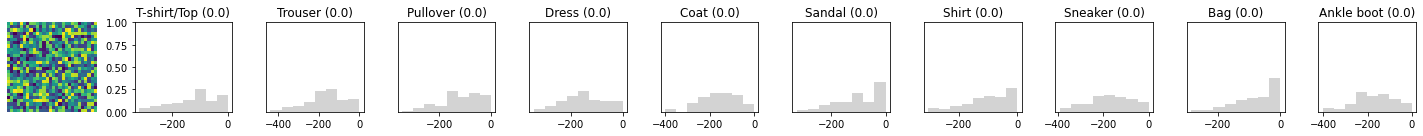

Real: Bag ===> Predicted: Undecided.
Summary
Total images:  1
Predicted for:  0
-------------------------------------------------------------


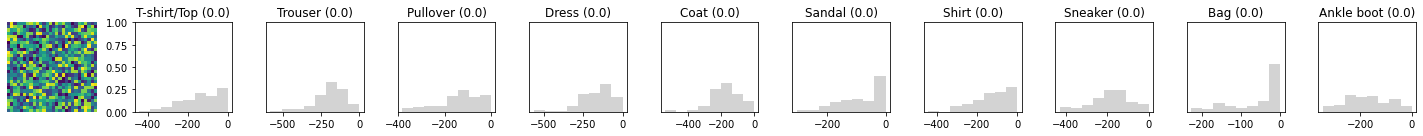

Real: Ankle boot ===> Predicted: Undecided.
Summary
Total images:  1
Predicted for:  0


(1, 0, 0)

In [48]:
#@title
noisy_images, fake_labels = torch.rand(images[:1].shape), torch.randint(0,  10, labels[:1].shape)
test_batch(noisy_images, fake_labels)

noisy_images, fake_labels = torch.rand(images[:1].shape), torch.randint(0,  10, labels[:1].shape)
test_batch(noisy_images, fake_labels)

noisy_images, fake_labels = torch.rand(images[:1].shape), torch.randint(0,  10, labels[:1].shape)
test_batch(noisy_images, fake_labels)

## 3.3. Exemplos da base de teste

Esta amostra permite visualizar a imagem de entrada com as distribuições correpondentes a cada classe para, mediante análise manual, identifificar as situações em que o modelo indiciou "indecisão". 

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


-------------------------------------------------------------


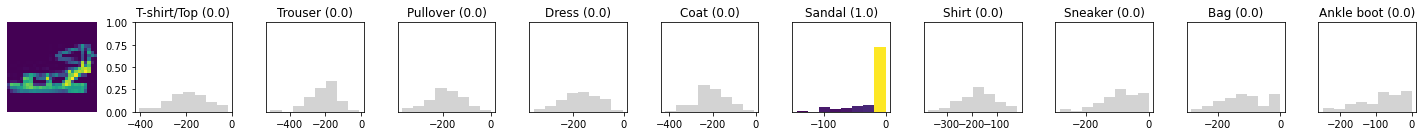

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


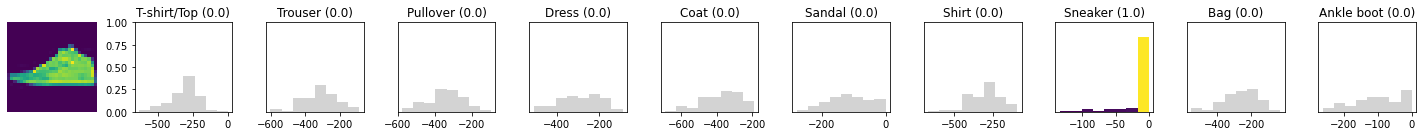

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


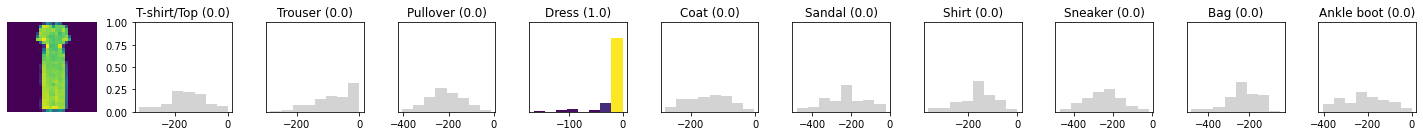

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


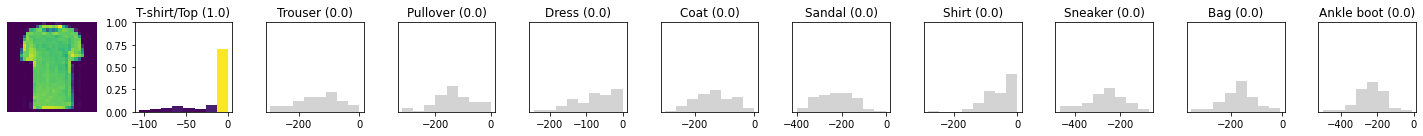

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


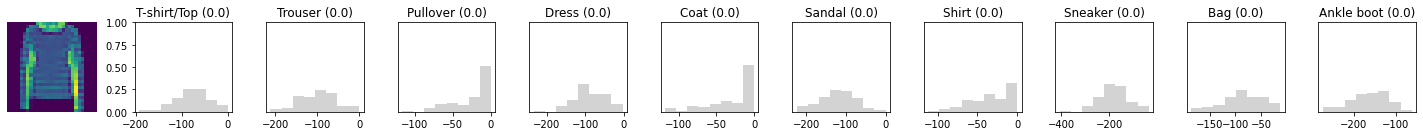

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


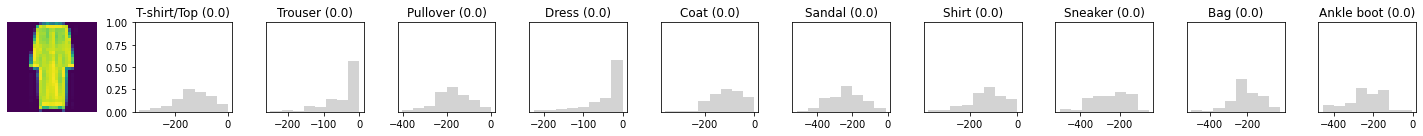

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


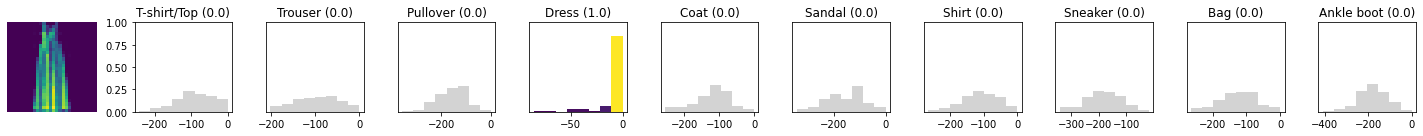

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


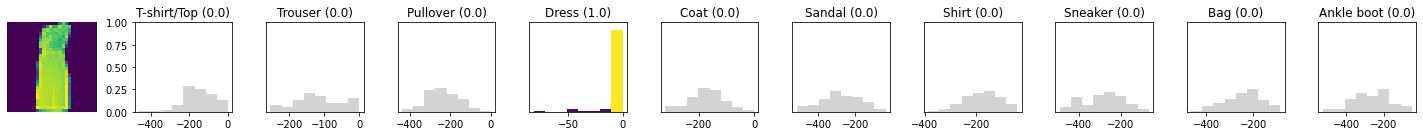

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


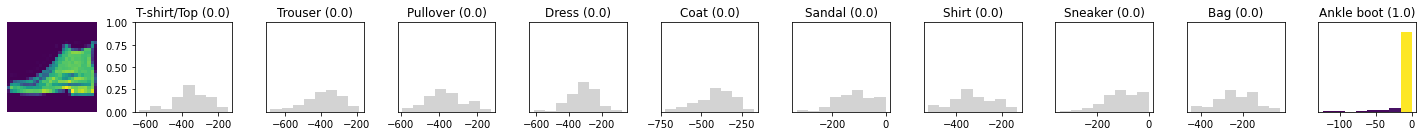

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


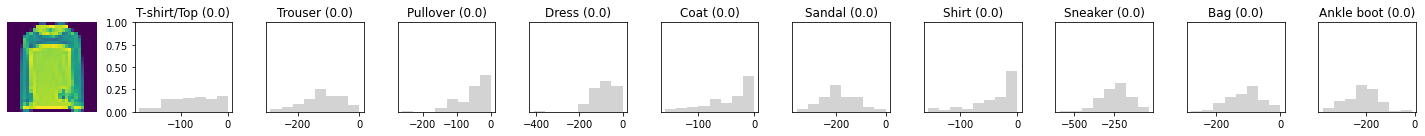

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


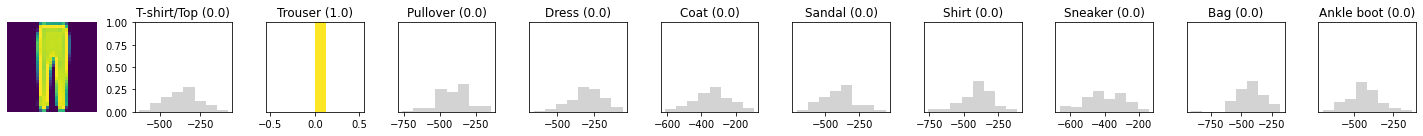

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


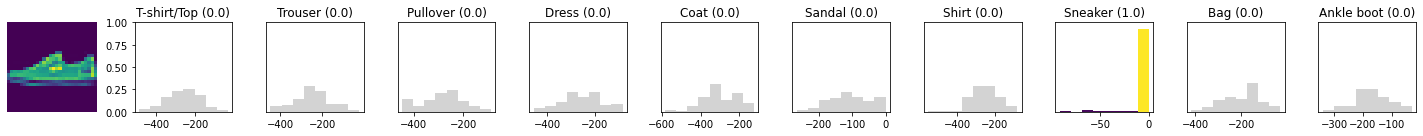

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


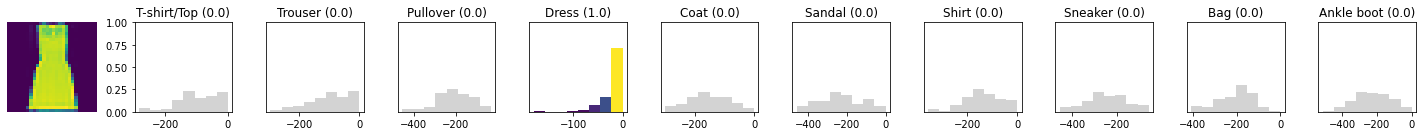

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


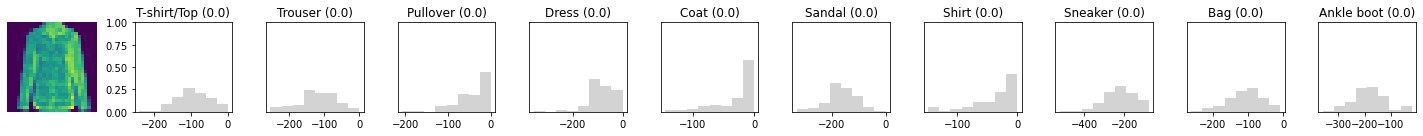

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


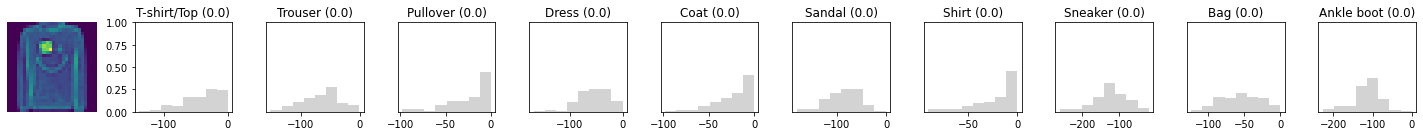

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


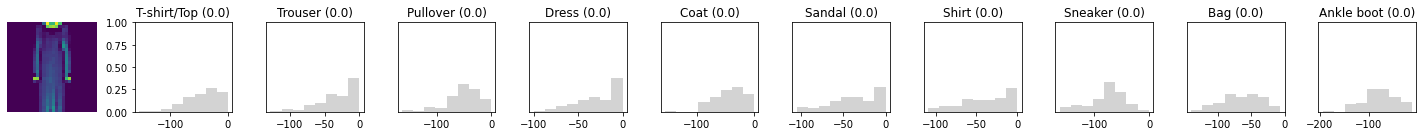

Real: Dress ===> Predicted: Undecided.
-------------------------------------------------------------


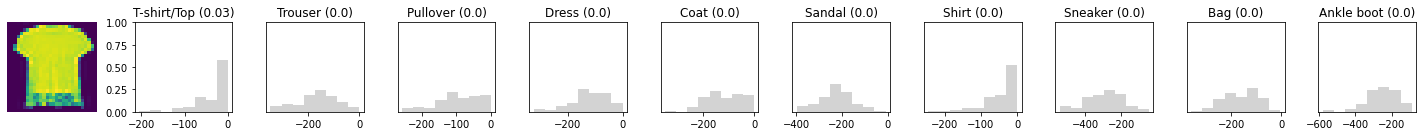

Real: T-shirt/Top ===> Predicted: Undecided.
-------------------------------------------------------------


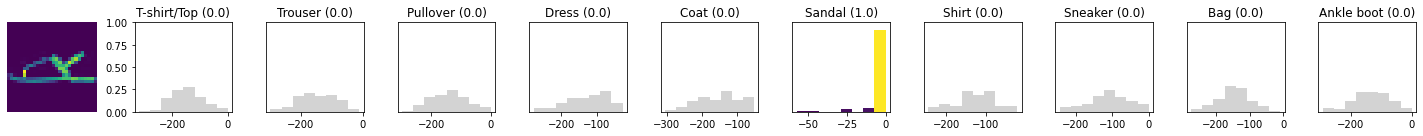

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


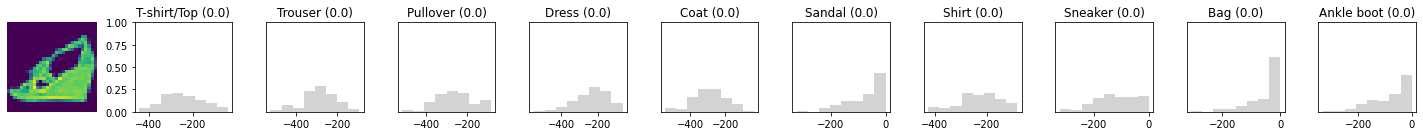

Real: Sandal ===> Predicted: Undecided.
-------------------------------------------------------------


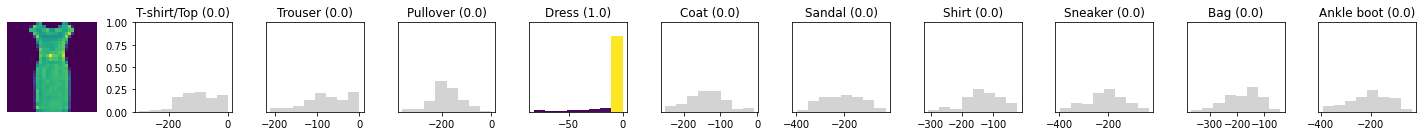

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


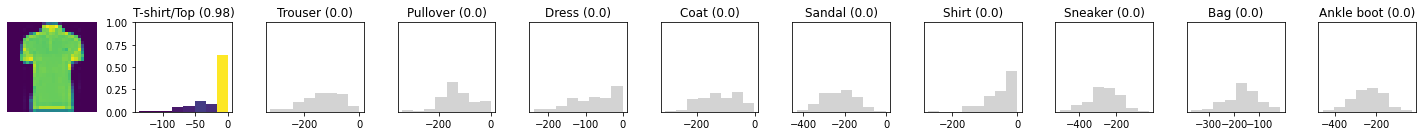

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


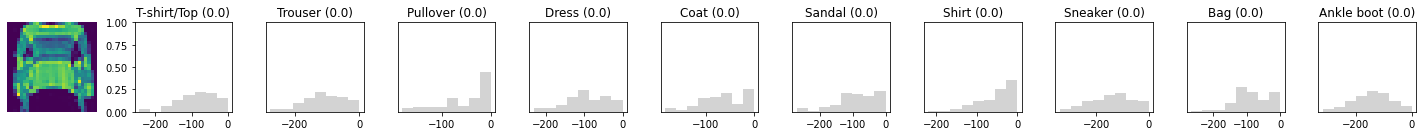

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


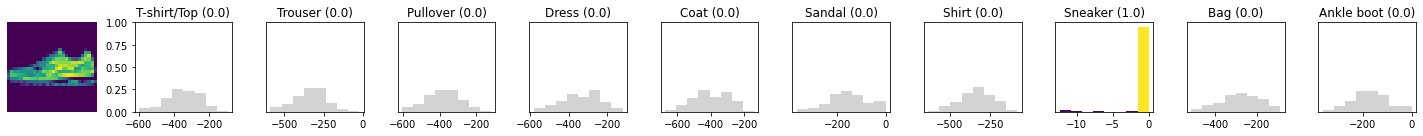

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


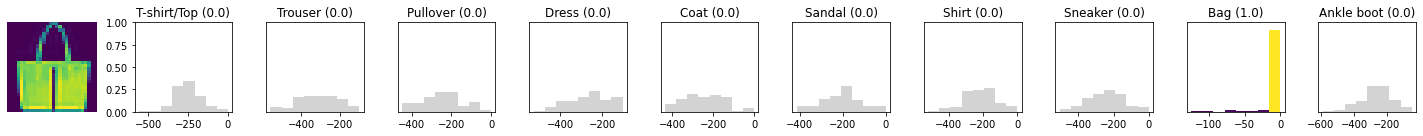

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


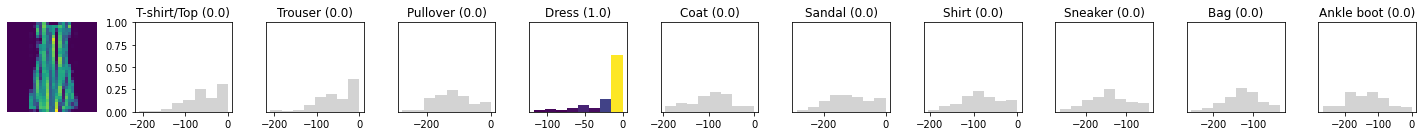

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


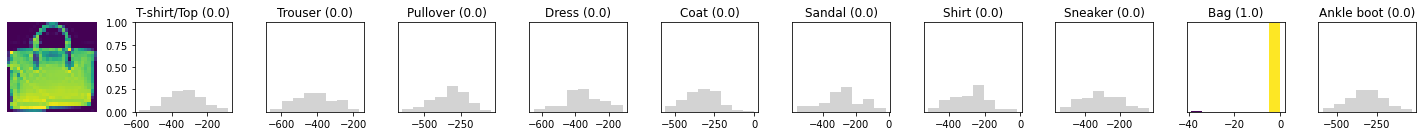

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


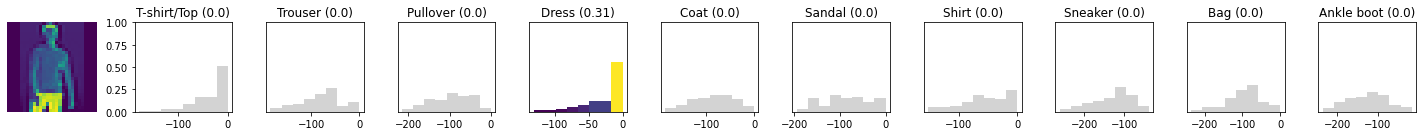

Real: Pullover ===> Predicted: Incorrect (Dress)
-------------------------------------------------------------


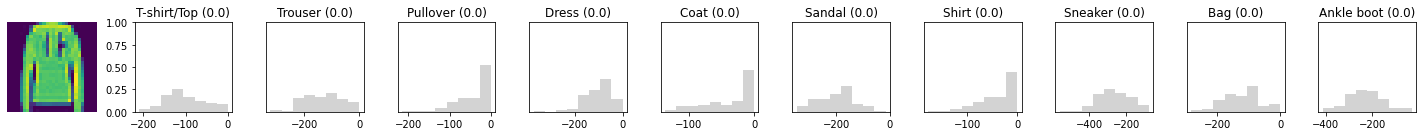

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


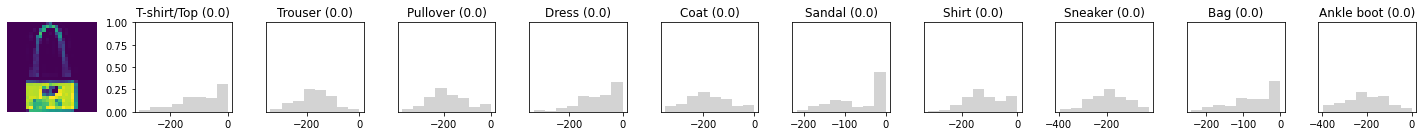

Real: Bag ===> Predicted: Undecided.
-------------------------------------------------------------


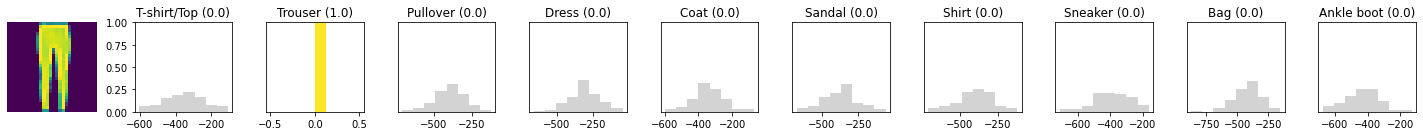

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


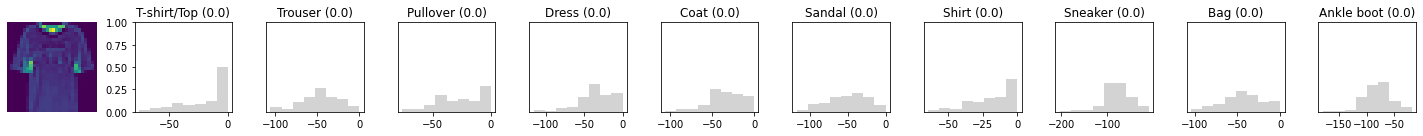

Real: T-shirt/Top ===> Predicted: Undecided.
-------------------------------------------------------------


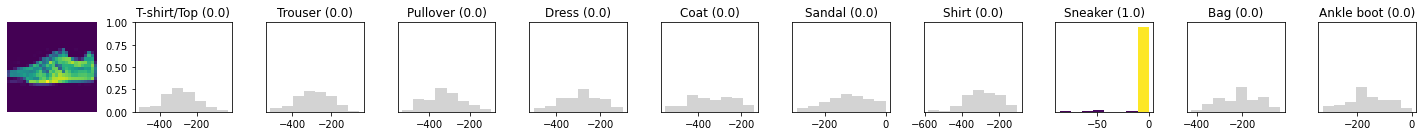

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


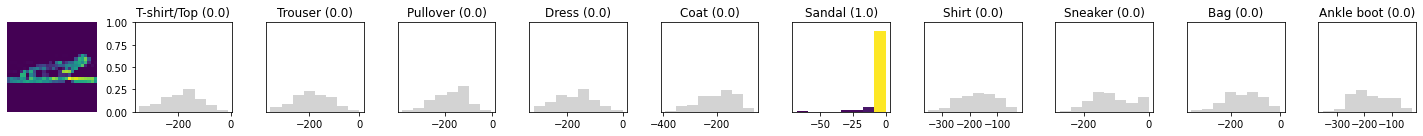

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


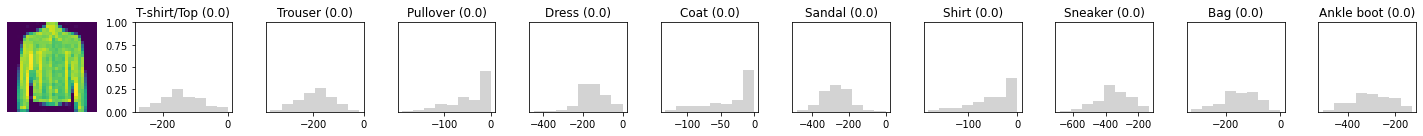

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


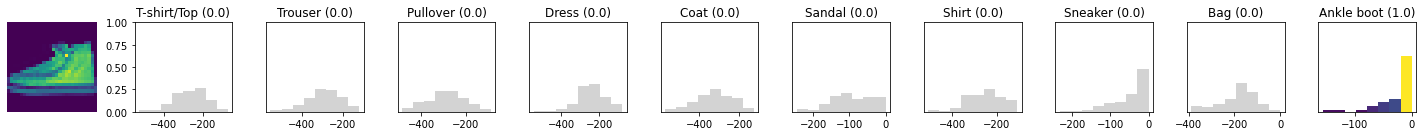

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


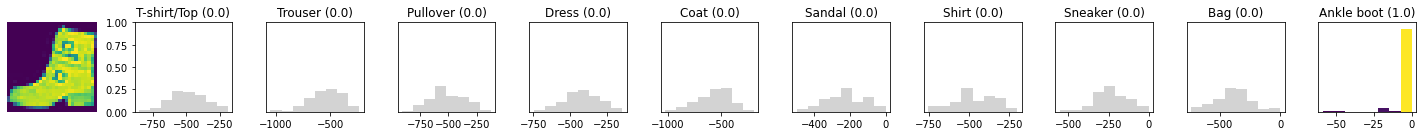

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


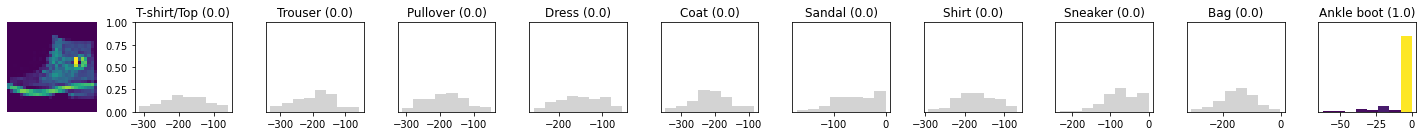

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


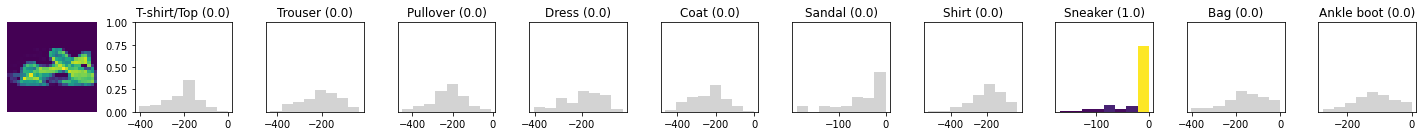

Real: Sandal ===> Predicted: Incorrect (Sneaker)
-------------------------------------------------------------


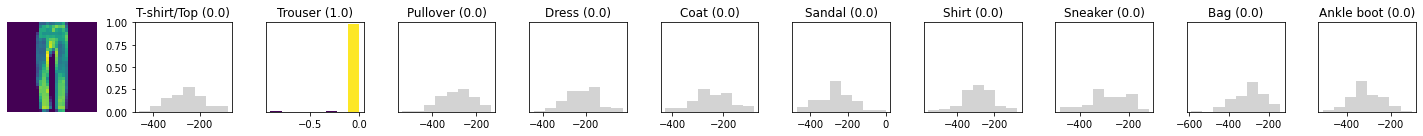

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


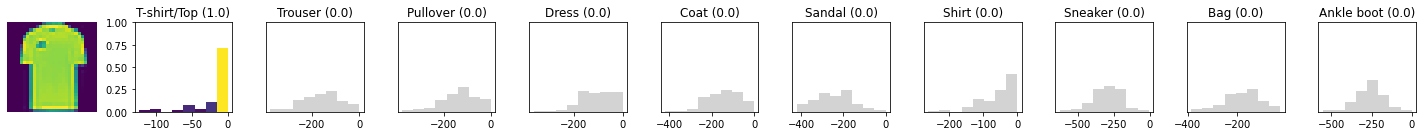

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


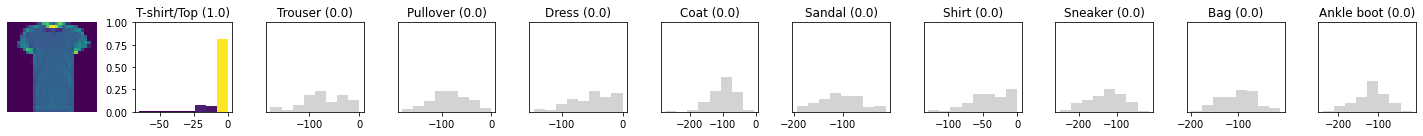

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


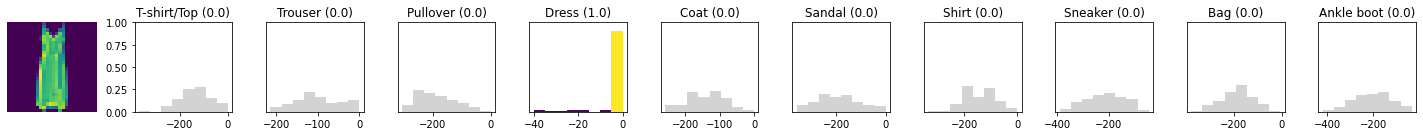

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


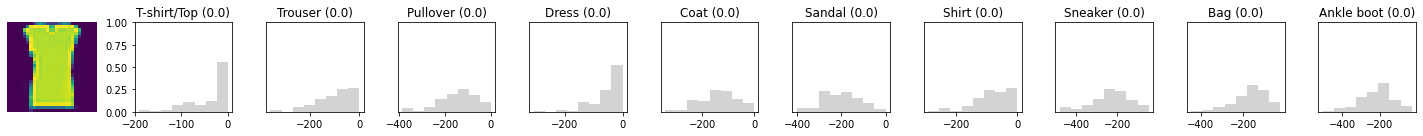

Real: T-shirt/Top ===> Predicted: Undecided.
-------------------------------------------------------------


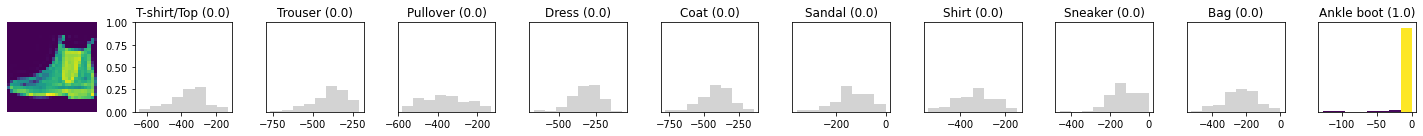

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


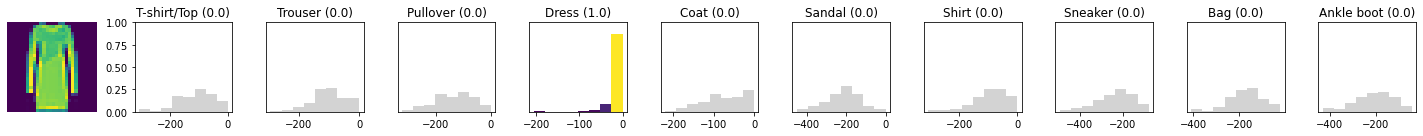

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


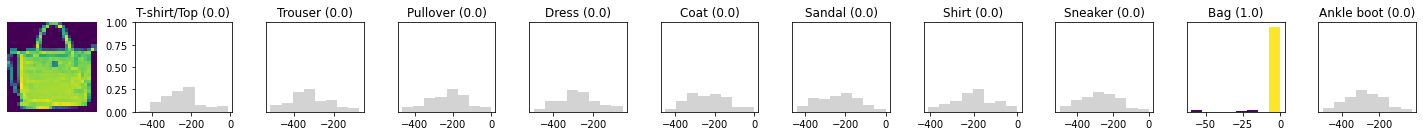

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


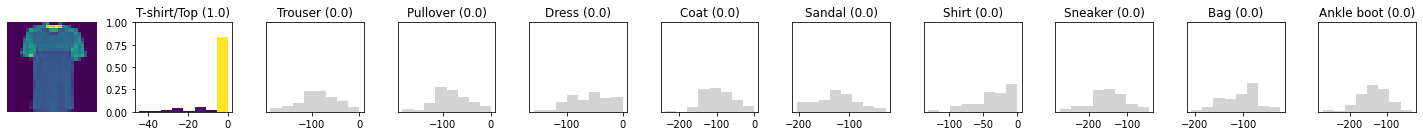

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


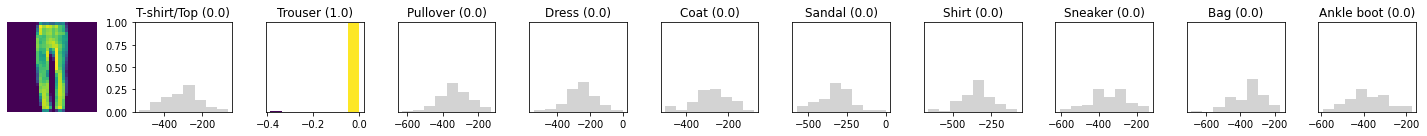

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


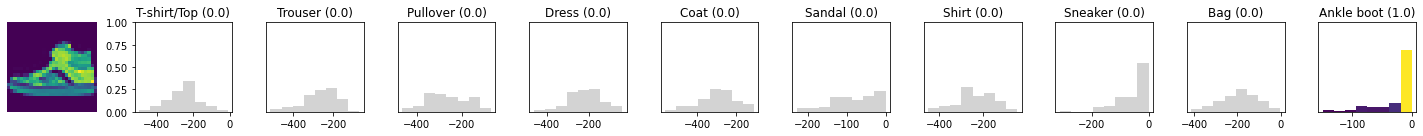

Real: Sneaker ===> Predicted: Incorrect (Ankle boot)
-------------------------------------------------------------


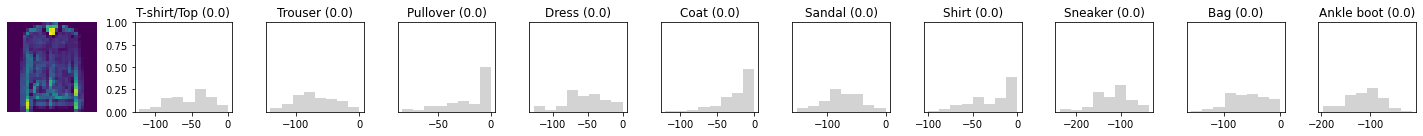

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


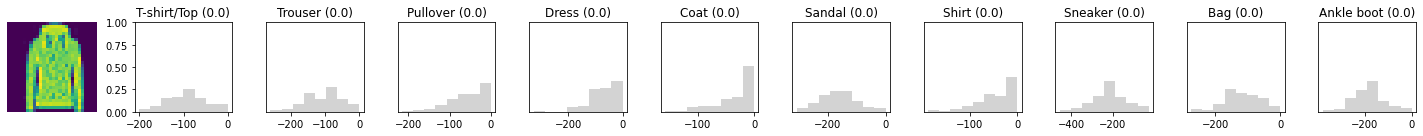

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


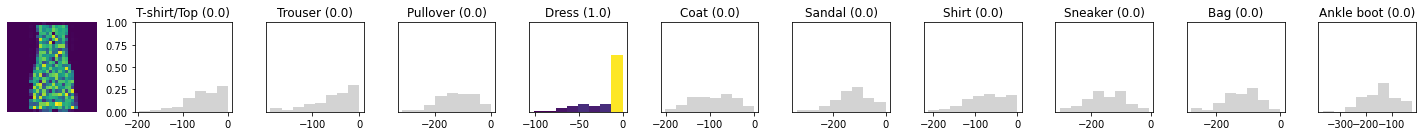

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


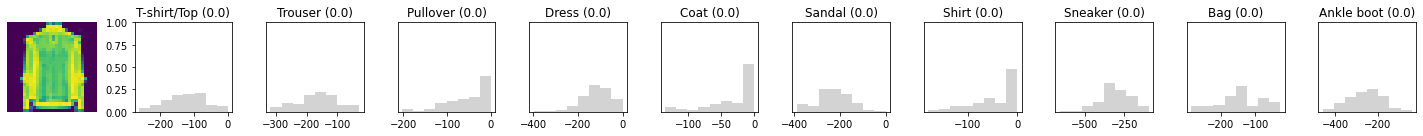

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


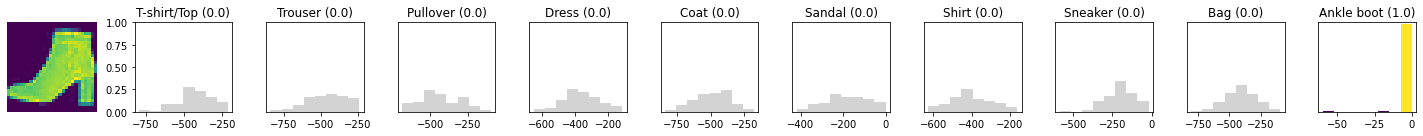

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


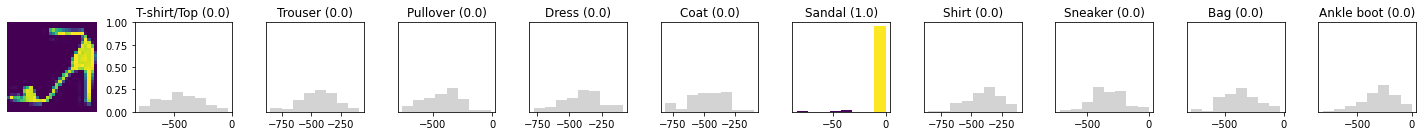

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


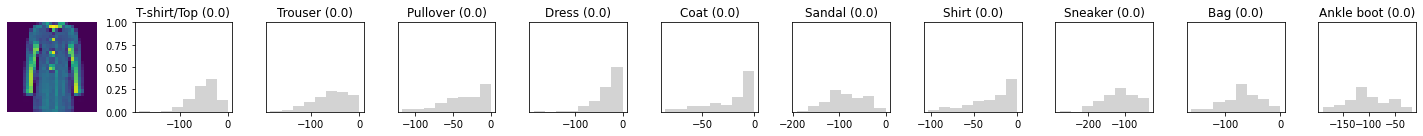

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


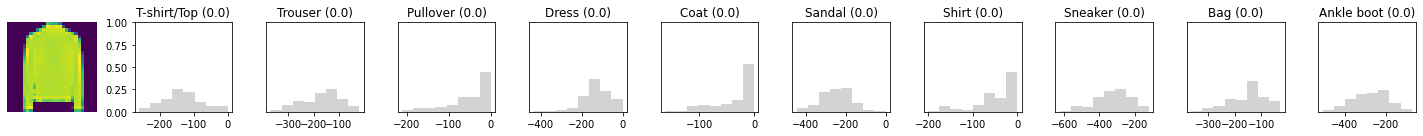

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


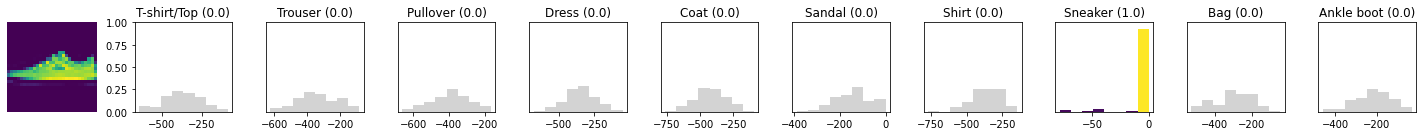

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


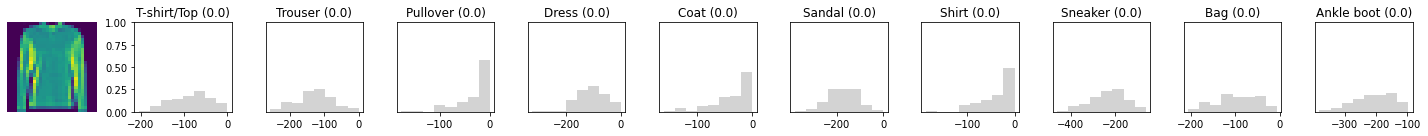

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


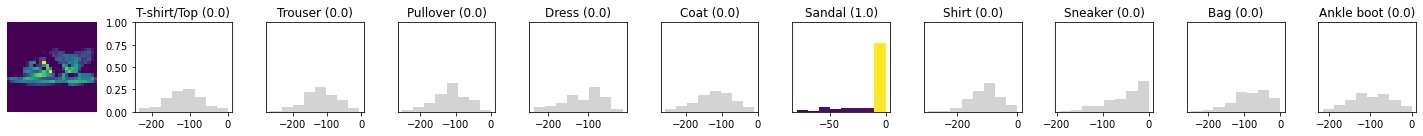

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


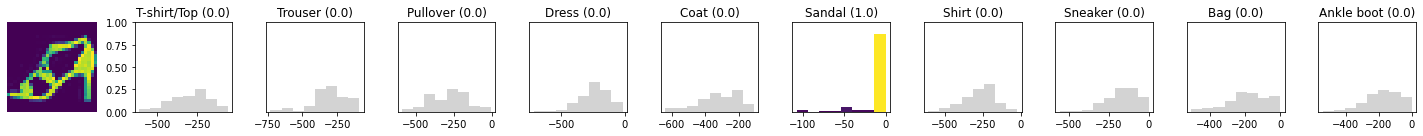

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


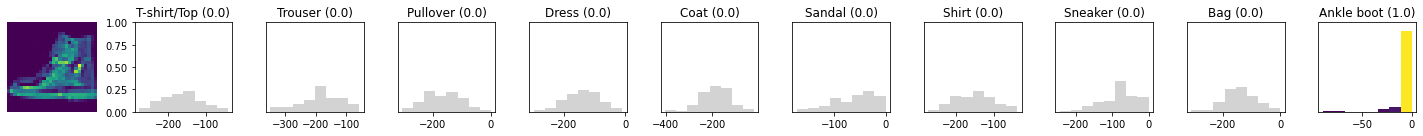

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


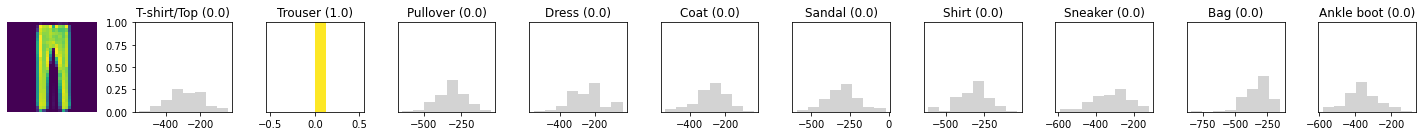

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


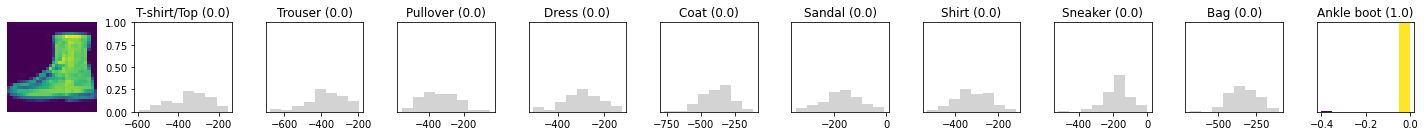

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


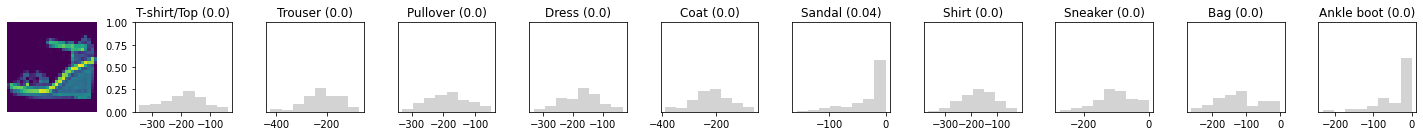

Real: Sandal ===> Predicted: Undecided.
-------------------------------------------------------------


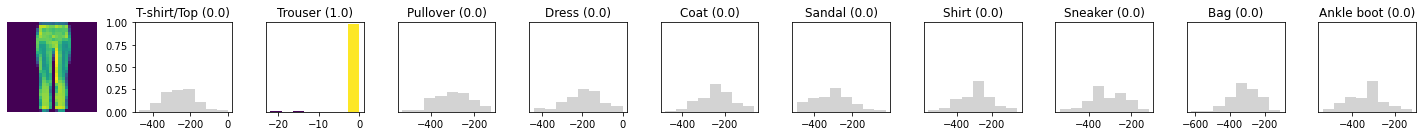

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


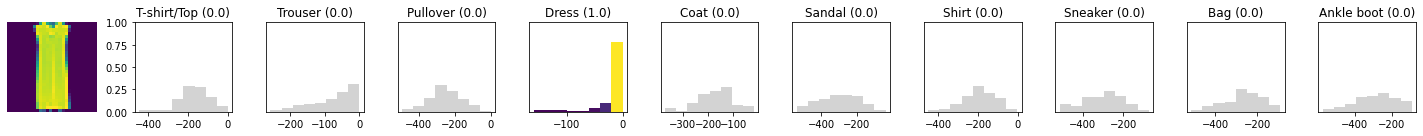

Real: Dress ===> Predicted: Correct
-------------------------------------------------------------


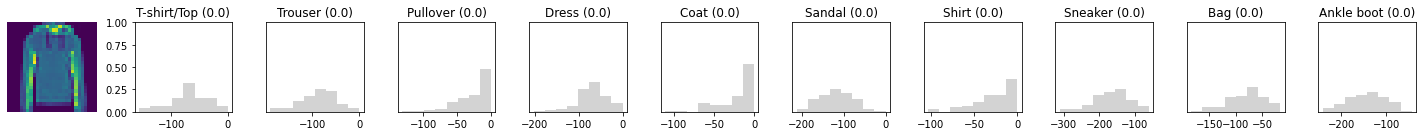

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


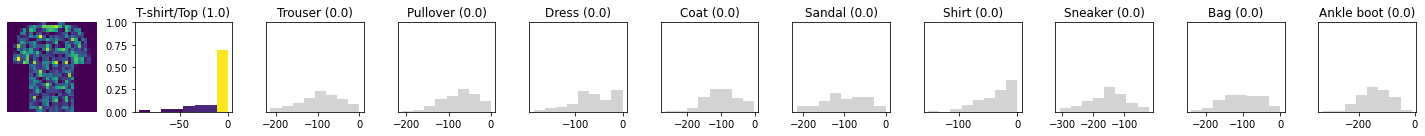

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


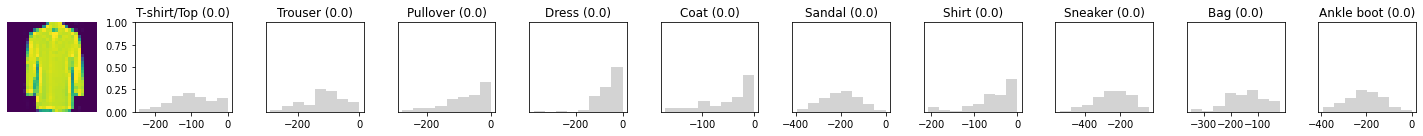

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


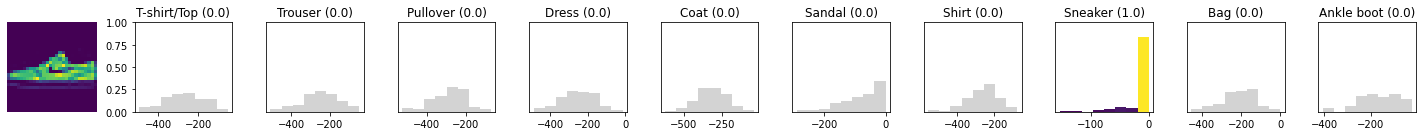

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


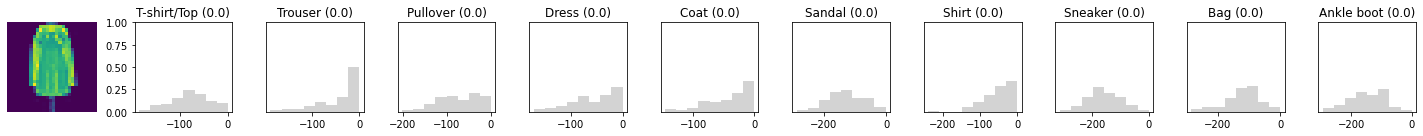

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


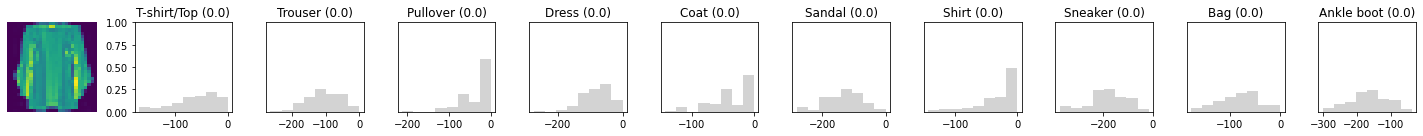

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


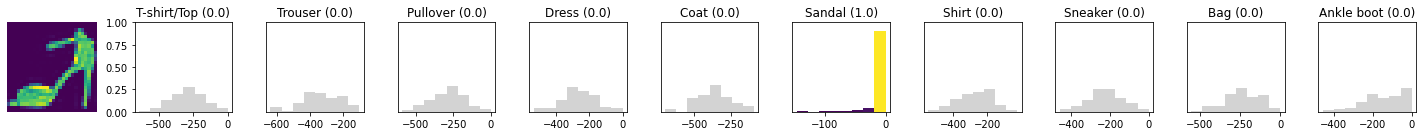

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


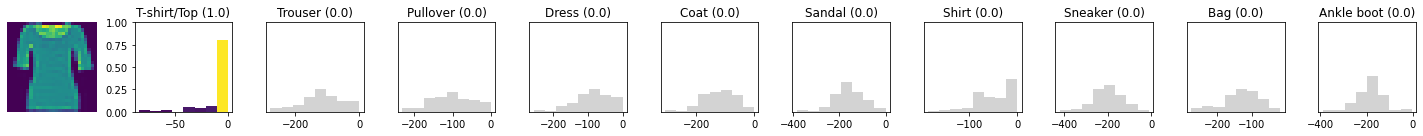

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


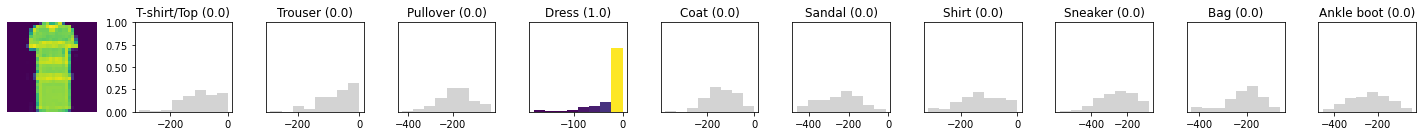

Real: T-shirt/Top ===> Predicted: Incorrect (Dress)
-------------------------------------------------------------


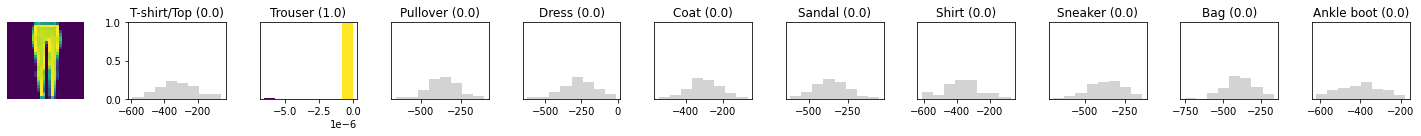

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


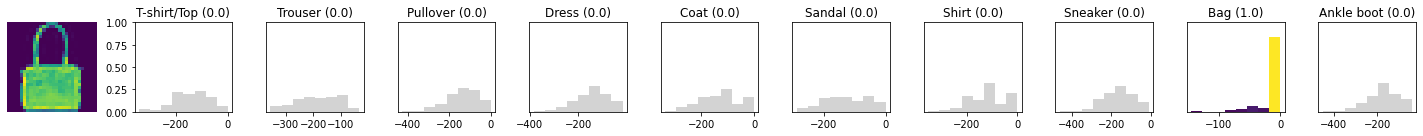

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


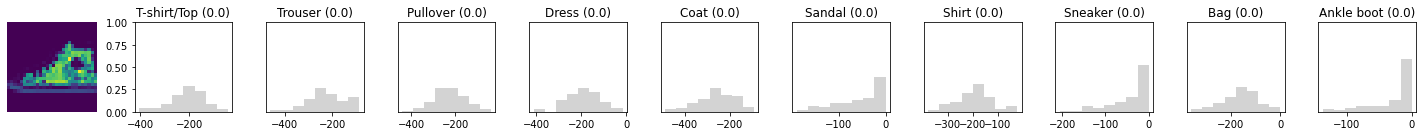

Real: Sneaker ===> Predicted: Undecided.
-------------------------------------------------------------


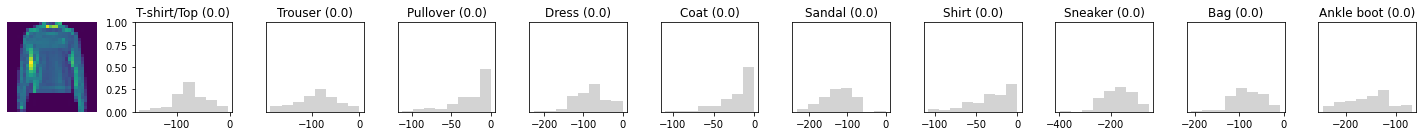

Real: Pullover ===> Predicted: Undecided.
-------------------------------------------------------------


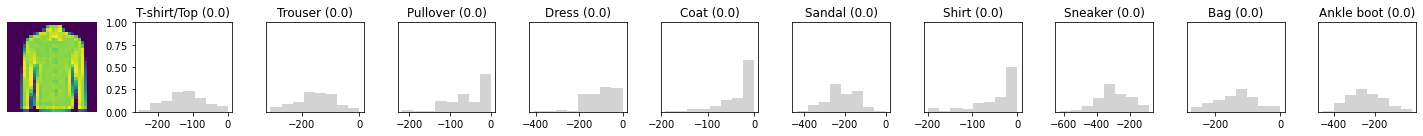

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


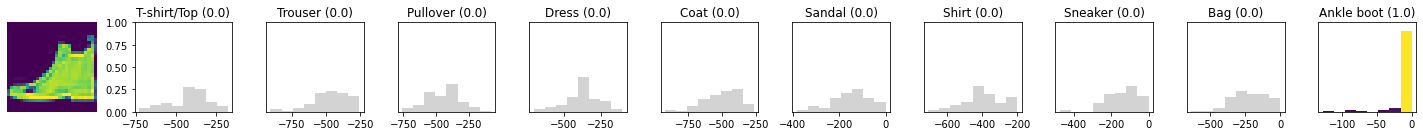

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


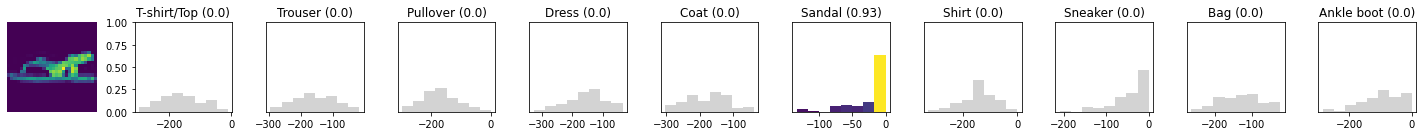

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


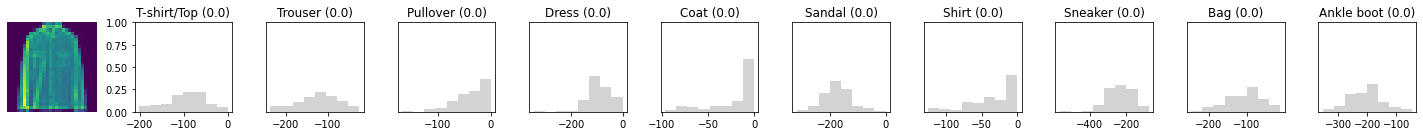

Real: Shirt ===> Predicted: Undecided.
-------------------------------------------------------------


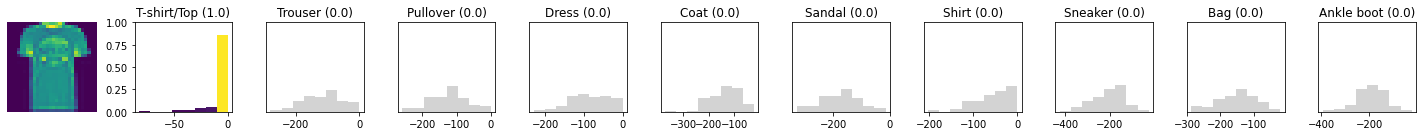

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


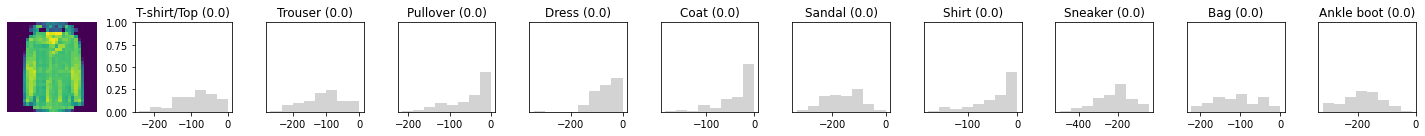

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


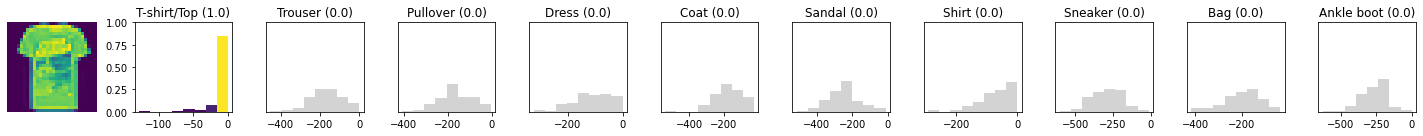

Real: T-shirt/Top ===> Predicted: Correct
-------------------------------------------------------------


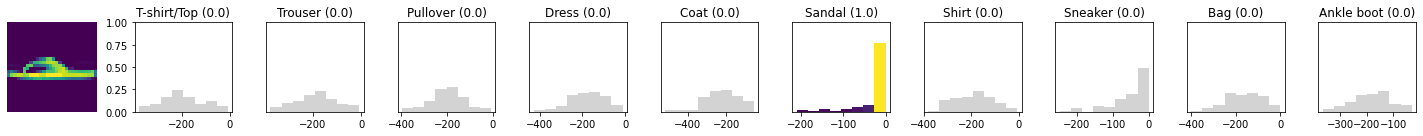

Real: Sandal ===> Predicted: Correct
-------------------------------------------------------------


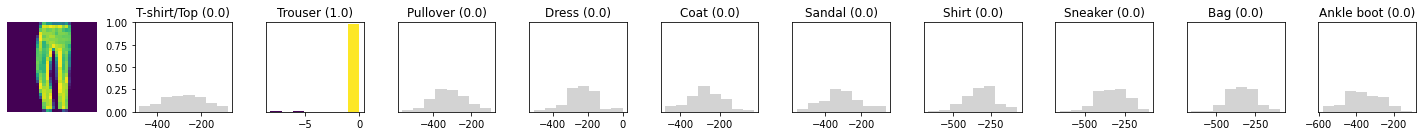

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


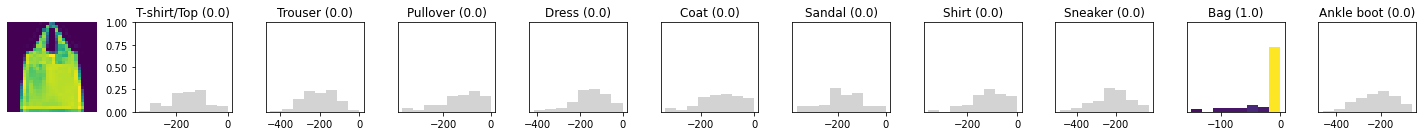

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


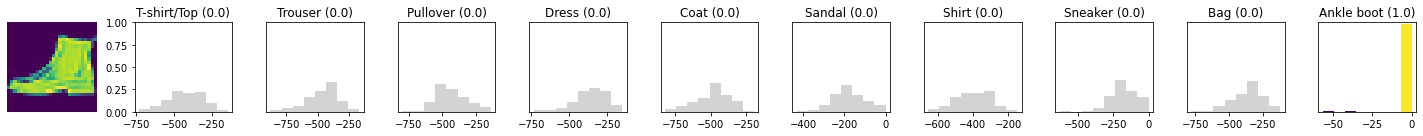

Real: Ankle boot ===> Predicted: Correct
-------------------------------------------------------------


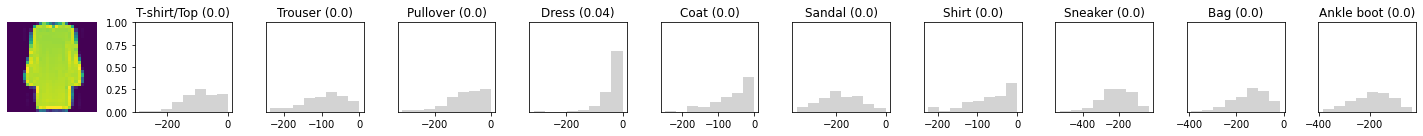

Real: Dress ===> Predicted: Undecided.
-------------------------------------------------------------


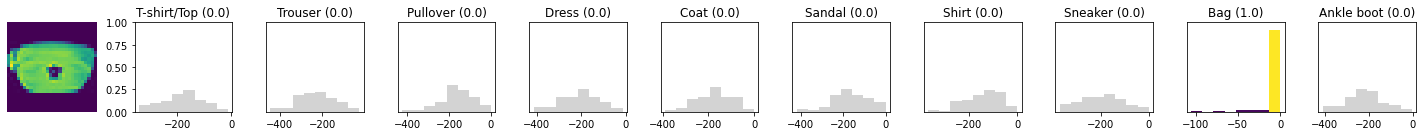

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


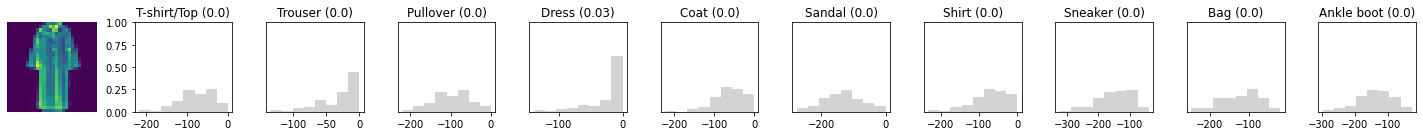

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


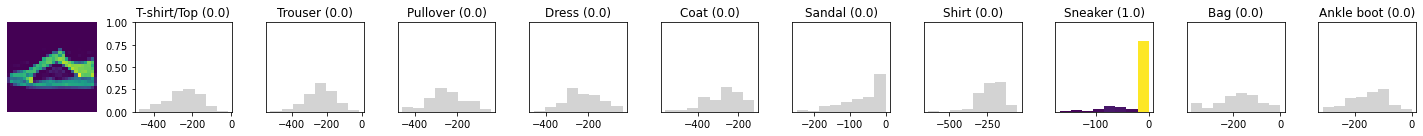

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


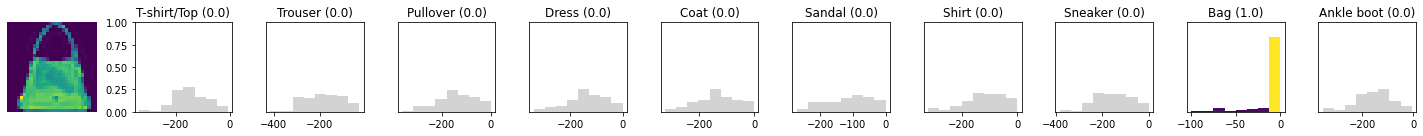

Real: Bag ===> Predicted: Correct
-------------------------------------------------------------


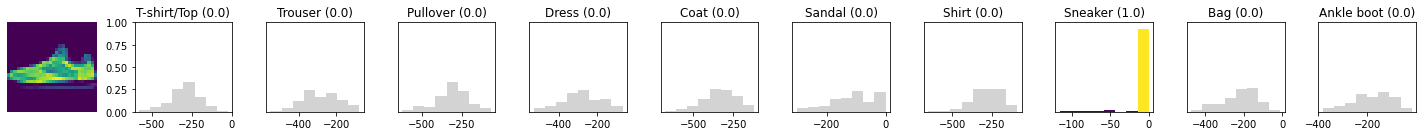

Real: Sneaker ===> Predicted: Correct
-------------------------------------------------------------


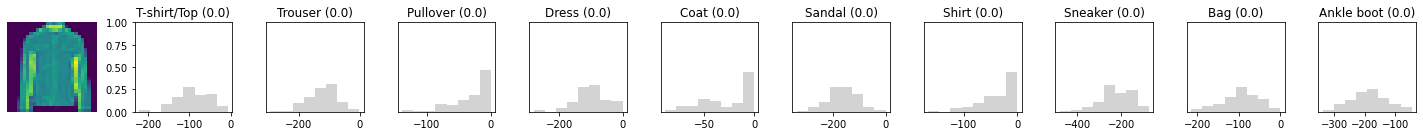

Real: Coat ===> Predicted: Undecided.
-------------------------------------------------------------


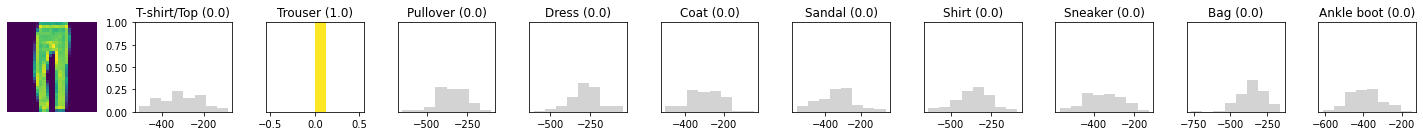

Real: Trouser ===> Predicted: Correct
-------------------------------------------------------------


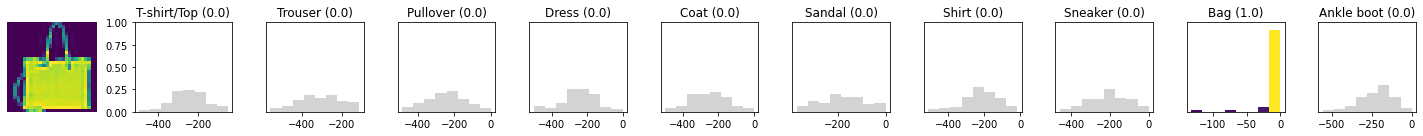

Real: Bag ===> Predicted: Correct
Summary
Total images:  100
Predicted for:  67
Accuracy when predicted:  0.9402985074626866


(100, 63.0, 67)

In [47]:
#@title
dataiter = iter(test_loader)
images, labels = dataiter.next()

test_batch(images[:100], labels[:100])

# 4. Considerações Finais

O conjunto de dados Fashion Mnist tem muita ambiguidade entre suas classes. Nas fronteiras, as classes tem muitas características similares:

* vestidos curtos parecem camisetas;
* chinelos fechados parecem tenis;
* tenis mais altos parecem botas;
* agasalhos parecem camisetas; e
* etc.

Apesar de diversos casos de dúvida do modelo serem meio óbvios para seres humanos, é importante lembrar que a rede neural utilizada tem baixa quantidade de neurônios e nem mesmo convoluções foram utilizadas.

Os principais motivos de indecisão do modelo foram:
* as situações de fronteira mencionadas acima;
* imagens de qualidade ruins com baixo contraste ou mal enquadradas.

Tais classificações de indecisão parecem corretas e bem razoáveis. Se os critérios da rede fossem alterados para ser menos sensíveis as indecisões a acurácia cairia bastante. 

A declaração de indecisão também seria útil para separar o conjunto de dados e treinar uma segunda rede neural. Como os casos evidentes são mais numerosos, a rede neural pode usar a forma básica para alcançar uma boa acurácia. Tirando estes casos, a próxima rede neural seria forçada a descobrir outras características para diferenciar as classes, caso elas existam. 

 # Referências:
* CHOPRAS, P; 2018; Making Your Neural Network Say “I Don’t Know” — Bayesian NNs using Pyro and PyTorch; Em: Towards Data Science; Disponível em: https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd; Acesso Em: 30-SET-2021

* GUERIN Júnior, N. D.; 2021; Redes Neurais Bayesianas; Em: Inferência Bayesiana em Machine Learning, Turma 2021-1, Curso de Inteligência Artificial, IESB; Disponível em: https://colab.research.google.com/drive/1HCf4dOv3n2cqGWR0fnxyMz8BZByaw4Sd?usp=sharing#scrollTo=iu2okyYmghEc